## Gait Analysis on  Belt Sensor Dataset

###  ML Model

In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import pathlib
import csv

C:\Users\adanent\Anaconda3\envs\Annotation_tool\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
df = pd.read_csv('C:/Users/adanent/Documents/1_SDDE Seminar/belt_sensor_all.csv')
df.shape

(108170, 21)

In [3]:
### Low Pass filter 
from scipy import signal
def butter_lowpass(cutoff, nyq_freq, order=4):
    normal_cutoff = float(cutoff) / nyq_freq
    b, a = signal.butter(order, normal_cutoff, btype='lowpass')
    return b, a

def butter_lowpass_filter(data, cutoff_freq, nyq_freq, order=4):
    b, a = butter_lowpass(cutoff_freq, nyq_freq, order=order)
    y = signal.filtfilt(b, a, data)
    return y

In [4]:
#low pass filter
lowpass_filtred=[]
dfm=df[['S1_Ax', 'S1_Ay', 'S1_Az', 'S1_Gx', 'S1_Gy','S1_Gz', 'S2_Ax', 'S2_Ay', 'S2_Az', 'S2_Gx', 'S2_Gy', 'S2_Gz', 'S3_Ax',
       'S3_Ay', 'S3_Az', 'S3_Gx', 'S3_Gy', 'S3_Gz']]
for column in dfm.columns:# iterate over each column in raw_df
    cutoff_frequency = 15.0
    sample_rate=100
    t_signal=np.array(dfm[column]) #copie the signal values in 1D numpy array
    y = butter_lowpass_filter(t_signal,cutoff_frequency,sample_rate/2) 
    lowpass_filtred.append(y)
lowpass=pd.DataFrame(lowpass_filtred)
lowpass=lowpass.T
lowpass.columns=['S1_Ax', 'S1_Ay', 'S1_Az', 'S1_Gx', 'S1_Gy','S1_Gz', 'S2_Ax', 'S2_Ay', 'S2_Az', 'S2_Gx', 'S2_Gy', 'S2_Gz', 'S3_Ax',
       'S3_Ay', 'S3_Az', 'S3_Gx', 'S3_Gy', 'S3_Gz']
df1=df[['Pid','timestamp']]
df_filtred=pd.concat([df1,lowpass],axis=1)
df_filtred['Label']=df['Label']

In [5]:
from imblearn.over_sampling import SMOTE

# split data into input and output elements
X = df_filtred[['S1_Ax', 'S1_Ay', 'S1_Az', 'S1_Gx', 'S1_Gy',
       'S1_Gz', 'S2_Ax', 'S2_Ay', 'S2_Az', 'S2_Gx', 'S2_Gy', 'S2_Gz', 'S3_Ax',
       'S3_Ay', 'S3_Az', 'S3_Gx', 'S3_Gy', 'S3_Gz']]
y = df_filtred[['Label']]

oversample = SMOTE()
Xo, yo = oversample.fit_resample(X, y)

df_Smoted=pd.concat([Xo,yo],axis=1)
print(df_Smoted.shape)
df_Smoted.head(2)

#Label encoding
df_Smoted['Label_id']=df_Smoted['Label']
dff=df_Smoted.replace({'Label_id': {'Downstairs':0,'Walking':1,'Upstairs':2,
                        'Sitting':3,'Laying':4,'Standing':5}})

(176070, 19)


In [6]:
### Normalize/Standardize data
from sklearn.preprocessing import StandardScaler, LabelEncoder
X = dff[['S1_Ax', 'S1_Ay', 'S1_Az', 'S1_Gx', 'S1_Gy','S1_Gz', 'S2_Ax', 'S2_Ay', 'S2_Az', 'S2_Gx', 'S2_Gy', 'S2_Gz', 'S3_Ax',
       'S3_Ay', 'S3_Az', 'S3_Gx', 'S3_Gy', 'S3_Gz']]
y = dff['Label_id']
scaler = StandardScaler()
dx = scaler.fit_transform(X)

df_scaled = pd.DataFrame(data = dx, columns = X.columns)
df_scaled['Label_id'] = y.values

In [7]:
## Segmentation (window Preparation)
import scipy.stats as stats
Fs = 100
segment_size = 500 # fs*3 # window size=n_time steps=frame size
step_size = 50  #  Fs/2 # step size is related to window overlap
n_features = 18
def get_segments(df, segment_size, step_size):

    segments = []
    labels = []
    
    for i in range(0, len(df) - segment_size - 1, step_size):
        S1Ax = df_scaled['S1_Ax'].values[i: i + segment_size]
        S1Ay = df_scaled['S1_Ay'].values[i: i + segment_size]
        S1Az = df_scaled['S1_Az'].values[i: i + segment_size]
        S1Gx = df_scaled['S1_Gx'].values[i: i + segment_size]
        S1Gy = df_scaled['S1_Gy'].values[i: i + segment_size]
        S1Gz = df_scaled['S1_Gz'].values[i: i + segment_size]
        
        S2Ax = df_scaled['S2_Ax'].values[i: i + segment_size]
        S2Ay = df_scaled['S2_Ay'].values[i: i + segment_size]
        S2Az = df_scaled['S2_Az'].values[i: i + segment_size]
        S2Gx = df_scaled['S2_Gx'].values[i: i + segment_size]
        S2Gy = df_scaled['S2_Gy'].values[i: i + segment_size]
        S2Gz = df_scaled['S2_Gz'].values[i: i + segment_size]
        
        
        S3Ax = df_scaled['S3_Ax'].values[i: i + segment_size]
        S3Ay = df_scaled['S3_Ay'].values[i: i + segment_size]
        S3Az = df_scaled['S3_Az'].values[i: i + segment_size]
        S3Gx = df_scaled['S3_Gx'].values[i: i + segment_size]
        S3Gy = df_scaled['S3_Gy'].values[i: i + segment_size]
        S3Gz = df_scaled['S3_Gz'].values[i: i + segment_size]
        
          # Retrieve the most often used label in this segment
        label = stats.mode(df_scaled['Label_id'][i: i + segment_size])[0][0] ## [0][0] shows the current sequence
        
        #We used the dstack() to ensure that each array is stacked in such a way that
        #the features are separated in the third dimension, as we would prefer.
        segments.append(np.dstack([S1Ax, S1Ay, S1Az,S1Gx,S1Gy,S1Gz,S2Ax,S2Ay,S2Az, S2Gx,S2Gy,S2Gz,S3Ax,S3Ay,S3Az,S3Gx,S3Gy,S3Gz]))
        labels.append(label)

    # Bring the segments into a better shape
    segments=np.asarray(segments, dtype= np.float32).reshape(-1, segment_size, n_features)
    labels = np.asarray(pd.get_dummies(labels), dtype = np.float32)
        
    return segments, labels

In [8]:
X, y = get_segments(df_scaled, segment_size, step_size)

In [9]:
X.shape,y.shape, y.shape[0]

((3512, 500, 18), (3512, 6), 3512)

### DeepConvLSTM
A further extension of the CNN-LSTM idea is to perform the convolutions of the CNN (e.g.
how the CNN reads the input sequence data) as part of the LSTM. This combination is called
a Convolutional LSTM, or ConvLSTM for short, and like the CNN-LSTM is also used for
spatiotemporal data. The ConvLSTM2D class, by default, expects input data to have the shape:
**[samples, time, rows, cols, channels]**. Where each time step of data is defined as an
image of (rows × columns) data points.

In CNN-LSTM, we divided a given window of data (128 time steps) into four
subsequences of 32 time steps. We can use this same subsequence approach in defining the
ConvLSTM2D input where the number of time steps is the number of subsequences in the window,
the number of rows is 1 as we are working with one-dimensional data, and the number of
columns represents the number of time steps in the subsequence, in this case 32. For this chosen
framing of the problem, the input for the ConvLSTM2D would therefore be:

1.  **Samples**: n, for the number of windows in the dataset.
2.  **Time**: 4, for the four subsequences that we split a window of 128 time steps into.
3.  **Rows**: 1, for the one-dimensional shape of each subsequence.
4.  **Columns**: 32, for the 32 time steps in an input subsequence.
5.  **Channels**: 3, for the 3 input variables.

In [10]:
# reshape data into time steps of sub-sequences
n_steps, n_length = 10, 50
df_X = X.reshape((X.shape[0], n_steps, n_length, n_features))
n_outputs = y.shape[1] #n_outputs= 6

The ConvLSTM2D class requires configuration both in terms of the CNN and the LSTM. This
includes specifying the number of filters (e.g. 64), the two-dimensional kernel size, in this case
(1 row and 3 columns of the subsequence time steps), and the activation function, in this case
rectified linear. As with a CNN or LSTM model, the output must be flattened into one long
vector before it can be interpreted by a dense layer

In [11]:
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import ConvLSTM2D

In [12]:
#from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from scikeras.wrappers import KerasClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV 
from sklearn.model_selection import train_test_split

In [13]:
# split data into training set and test set
X_train_main, X_test, y_train_main, y_test = train_test_split(df_X, y,test_size=0.20, random_state=7)

# split training set into training and validation set
X_train, X_valid, y_train, y_valid = train_test_split(X_train_main,y_train_main,test_size=0.30,random_state=7)

In [14]:
X_train.shape, X_test.shape,y_train.shape,y_test.shape

((1966, 10, 50, 18), (703, 10, 50, 18), (1966, 6), (703, 6))

In [15]:
n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], y_train.shape[1]

# reshape data into time steps of sub-sequences
n_steps, n_length,n_features = 10, 50,18

X_train = X_train.reshape((X_train.shape[0], n_steps, 1, n_length, n_features))
X_valid = X_valid.reshape((X_valid.shape[0], n_steps, 1, n_length, n_features))
X_test = X_test.reshape((X_test.shape[0], n_steps, 1, n_length, n_features))

In [16]:
def create_model(optimizer= 'rmsprop' , init= 'glorot_uniform' ):
    # define convlstm model
    model = Sequential()
    model.add(ConvLSTM2D(filters=64, kernel_size=(1,3),input_shape=(n_steps, 1, n_length, n_features)))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(n_outputs, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [17]:
### Initialize Model
convLSTM2D=create_model()

In [18]:
history = convLSTM2D.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=10, batch_size=50)

Epoch 1/10
40/40 [==============================] - 16s 322ms/step - loss: 1.0310 - accuracy: 0.6511 - val_loss: 0.7171 - val_accuracy: 0.7628
Epoch 2/10
40/40 [==============================] - 14s 353ms/step - loss: 0.5256 - accuracy: 0.8245 - val_loss: 0.4550 - val_accuracy: 0.8553
Epoch 3/10
40/40 [==============================] - 14s 349ms/step - loss: 0.2828 - accuracy: 0.9095 - val_loss: 0.2677 - val_accuracy: 0.9181
Epoch 4/10
40/40 [==============================] - 13s 324ms/step - loss: 0.1817 - accuracy: 0.9359 - val_loss: 0.2620 - val_accuracy: 0.9217
Epoch 5/10
40/40 [==============================] - 12s 305ms/step - loss: 0.1127 - accuracy: 0.9674 - val_loss: 0.3103 - val_accuracy: 0.8992
Epoch 6/10
40/40 [==============================] - 12s 306ms/step - loss: 0.0973 - accuracy: 0.9710 - val_loss: 0.2140 - val_accuracy: 0.9348
Epoch 7/10
40/40 [==============================] - 12s 314ms/step - loss: 0.0594 - accuracy: 0.9858 - val_loss: 0.2069 - val_accuracy: 0.9395

## Save model

In [19]:
convLSTM2D.save('DeepConvLSTM.h5')

###  Evaluate Model

In [20]:
# Make Predictions on test 
y_pred_valid = convLSTM2D.predict(X_valid) #class Prediction 

y_pred_valid[:5], #y_probs_test[:5]

27/27 [==============================] - 2s 51ms/step


(array([[2.1649837e-05, 9.9029154e-01, 9.6827205e-03, 6.7789915e-07,
         1.5944865e-06, 1.8099943e-06],
        [1.6712789e-04, 3.9545135e-05, 9.9867177e-01, 8.8531553e-04,
         2.2031825e-04, 1.5831070e-05],
        [1.4991379e-06, 1.2598556e-10, 2.5342914e-07, 1.7666209e-05,
         6.3770018e-03, 9.9360353e-01],
        [4.5835575e-05, 6.1213279e-09, 1.3428802e-06, 4.6761755e-07,
         1.1105536e-03, 9.9884182e-01],
        [7.8409769e-08, 4.6650211e-10, 1.5713196e-06, 6.1992314e-03,
         9.0408427e-01, 8.9714870e-02]], dtype=float32),)

In [21]:
y_pred_valid=np.argmax(y_pred_valid,axis=1) 
y_true_valid=np.argmax(y_valid,axis=1) 

y_true_valid.shape, y_pred_valid.shape

((843,), (843,))

In [22]:
### Evaluate Model using accuracy 
from sklearn.metrics import accuracy_score,classification_report
print("Valid  acc : {}".format(accuracy_score(y_true_valid, y_pred_valid)))
print("\n -------------Classification Report-------------\n")
print(classification_report(y_true_valid, y_pred_valid))

Valid  acc : 0.9383155397390273

 -------------Classification Report-------------

              precision    recall  f1-score   support

           0       0.98      0.93      0.95       129
           1       0.90      0.96      0.93       158
           2       0.95      0.91      0.93       151
           3       0.98      0.87      0.92       143
           4       0.90      0.98      0.94       131
           5       0.93      0.98      0.96       131

    accuracy                           0.94       843
   macro avg       0.94      0.94      0.94       843
weighted avg       0.94      0.94      0.94       843



In [23]:
y_pred_test = convLSTM2D.predict(X_test) #class Prediction 

y_pred_test=np.argmax(y_pred_test,axis=1) 
y_true_test=np.argmax(y_test,axis=1) 

y_true_test.shape, y_pred_test.shape

22/22 [==============================] - 1s 56ms/step


((703,), (703,))

In [24]:
import seaborn as sns
import sklearn.metrics as skm
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score as acc
from sklearn.metrics import confusion_matrix,classification_report
cm=confusion_matrix(y_true_test,y_pred_test)
print(cm)
print(acc(y_true_test,y_pred_test))
print(classification_report(y_true_test,y_pred_test))

[[ 95   6   0   0   0   4]
 [  0 103   3   0   0   0]
 [  2   6 122   3   0   0]
 [  0   1   5 102   7   1]
 [  0   0   1   1 114   2]
 [  3   0   0   0   1 121]]
0.9345661450924608
              precision    recall  f1-score   support

           0       0.95      0.90      0.93       105
           1       0.89      0.97      0.93       106
           2       0.93      0.92      0.92       133
           3       0.96      0.88      0.92       116
           4       0.93      0.97      0.95       118
           5       0.95      0.97      0.96       125

    accuracy                           0.93       703
   macro avg       0.94      0.93      0.93       703
weighted avg       0.94      0.93      0.93       703



In [25]:
cf=np.empty((6,6))
for i in range(6):
    cf[i]=(cm[i]/np.sum(cm[i]))

In [26]:
# group_counts = ["{0:.0f}".format(value) for value in cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()]
labels = [f"{v1}" for v1 in group_percentages]
labels = np.asarray(labels).reshape(6,6)

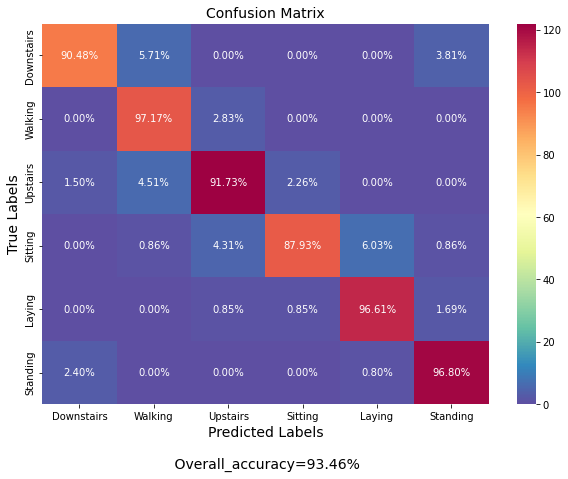

In [27]:
fig = plt.figure(figsize=(10,7))
ax=fig.add_subplot(111)
#sns.heatmap(cm, annot=labels,fmt="",cmap='RdYlBu_r',ax=ax)
sns.heatmap(cm, annot=labels,fmt="",cmap='Spectral_r',ax=ax)
ax.set_xlabel("Predicted Labels\n\n Overall_accuracy=""{0:.2%}".format((acc(y_true_test,y_pred_test))),size=14)
ax.set_ylabel("True Labels",size=14)
ax.set_title("Confusion Matrix",size=14)
ax.xaxis.set_ticklabels(['Downstairs','Walking','Upstairs','Sitting','Laying','Standing'])
ax.yaxis.set_ticklabels(['Downstairs','Walking','Upstairs','Sitting','Laying','Standing'])
plt.savefig('ConfusionMatrix_smart belt',dpi=1200, bbox_inches='tight')

In [32]:
from sklearn.metrics import precision_recall_fscore_support
precision_recall_fscore_support(y_true_test, y_pred_test, average='macro')

(0.9352052708096693, 0.9345275484658332, 0.9340733797520647, None)

In [29]:
from sklearn.metrics import precision_recall_fscore_support
p_r_f=precision_recall_fscore_support(y_true_test, y_pred_test, average='macro')
prf=list(p_r_f)
pdf_2 = prf[:-1]
np.round(pdf_2,4)

array([0.9352, 0.9345, 0.9341])

In [30]:
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

(<Figure size 504x504 with 1 Axes>,
 <AxesSubplot:xlabel='predicted label', ylabel='true label'>)

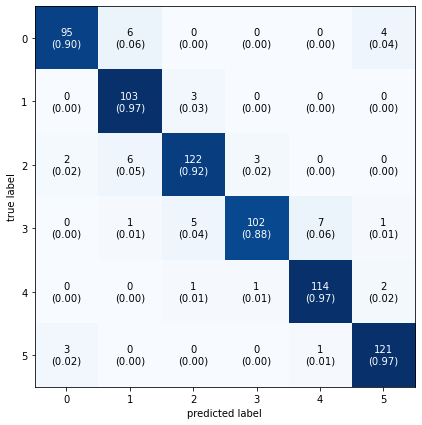

In [31]:
mat = confusion_matrix(y_true_test, y_pred_test)
plot_confusion_matrix(conf_mat=mat,show_normed=True, figsize=(7,7))